In [1]:
#Imported Required Libraries
!pip install torchsummary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import zipfile
import os
from google.colab import drive
import torchvision.models as models

In [2]:
#Check for GPU and Intialization of Batch_Size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ",device)
batch_num = 64

Device :  cuda


In [3]:
#Importing dataset from Google Drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/cnn_dataset.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:

     zip_ref.extractall(extract_path)

Mounted at /content/drive


In [4]:
#Transformations to be applied to every Image present in. the dataset
transform = transforms.Compose([
                                transforms.Resize((224, 224)), #Resize images to a 28x28 size
                                transforms.Grayscale(num_output_channels=1), #Convert the images to grayscale (1 channel) because the images are b/w
                                transforms.ToTensor(), #Convert into PyTorch tensors
                                transforms.Normalize((0.5,), (0.5,)) #Normalization
                                ])

#Dataset Loading
dataset = ImageFolder(root=os.path.join(extract_path, 'cnn_dataset'), transform=transform)

#jupyter notebook
#dataset = ImageFolder(root='cnn_dataset', transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 100800
    Root location: /content/dataset/cnn_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
#Creating Data Loader
data_loader = DataLoader(dataset, batch_size=batch_num, shuffle=True)

In [6]:
#Analysis of the dataset
images, labels = next(iter(data_loader))
image_shape = images[0].shape
print("Image Shape : ",image_shape)
print("\nImage Labels : ",labels)

num_of_channels = images[0].shape[0]
size_of_image = images[0].shape[1]

print("\nNumber of Channels : ",num_of_channels)
print("\nSize of Image : {}x{}".format(size_of_image, size_of_image))

Image Shape :  torch.Size([1, 224, 224])

Image Labels :  tensor([31, 14, 13, 17, 21, 30,  9, 21, 28,  1, 10,  6, 19, 18, 23, 20, 19, 10,
        19, 10,  9,  5, 27, 23, 27, 34, 18, 12, 16, 35, 28,  8, 10,  6,  2,  8,
        18, 10, 17, 16, 20,  1, 11, 30, 17, 26,  7, 25,  5, 15,  4,  5,  4, 34,
         7, 11, 32, 27,  0, 28,  5, 34, 17, 35])

Number of Channels :  1

Size of Image : 224x224


In [7]:
total_samples = len(dataset)

print("Total Number of Samples : ",total_samples)

total_classes = len(dataset.classes)
print("\nTotal Number of Classes : ",total_classes)

Total Number of Samples :  100800

Total Number of Classes :  36


In [8]:
#Splitting dataset in to Training, Validation and Testing
total_data = len(dataset)
train_data = int(0.7 * total_data)
val_data = int(0.15 * total_data)
test_data = total_data - train_data - val_data

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_data, val_data, test_data])

train_loader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_num, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_num, shuffle=False)

print('Training Data : ',train_data)
print('\nValidation Data : ',val_data)
print('\nTesting Data : ',test_data)

Training Data :  70560

Validation Data :  15120

Testing Data :  15120


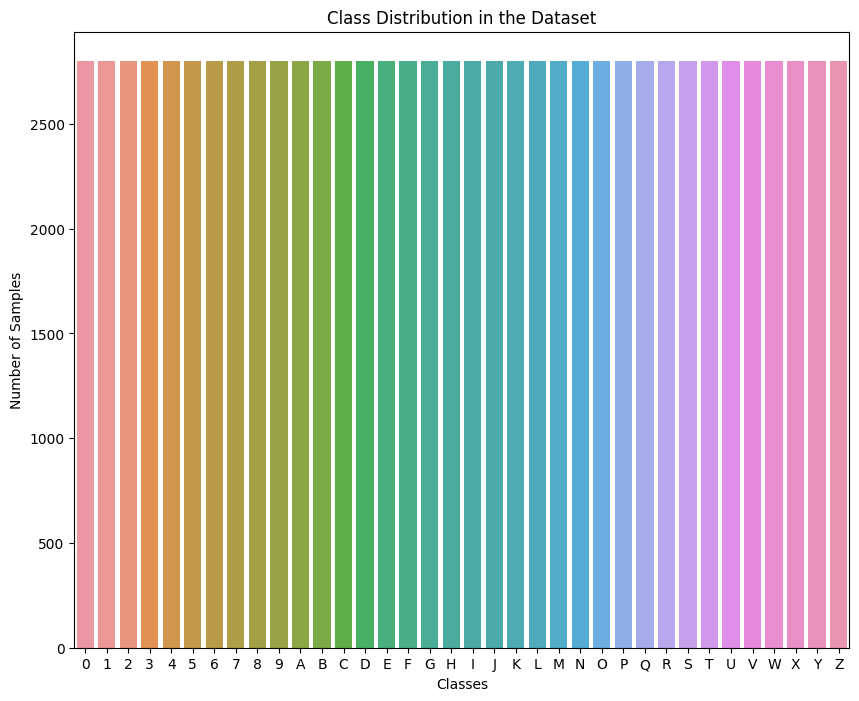

In [9]:
#Visualization 1 Number of Classes and Samples
distribution = {}

for _, label in dataset:

    distribution[dataset.classes[label]] = distribution.get(dataset.classes[label], 0) + 1

plt.figure(figsize=(10, 8))

sns.barplot(x=list(distribution.keys()), y=list(distribution.values()))

plt.title('Class Distribution in the Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

plt.show()

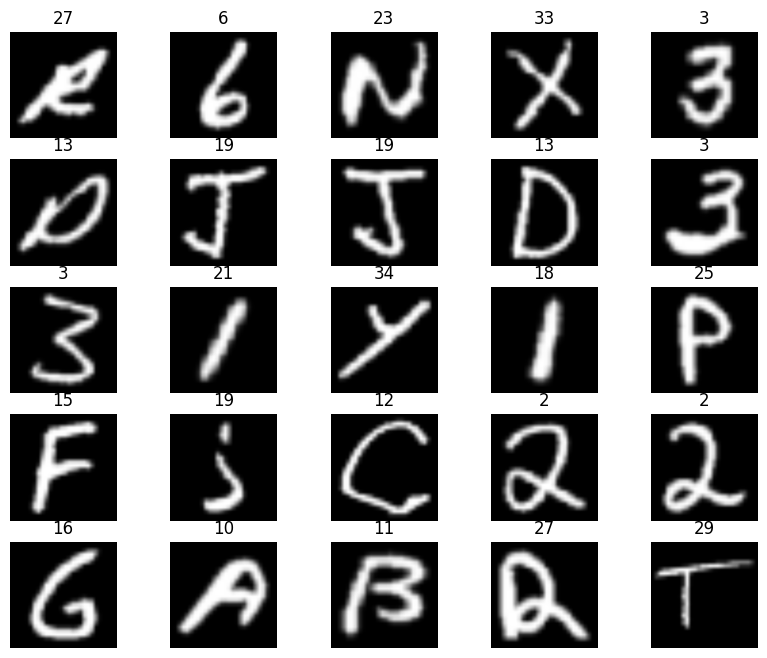

In [10]:
#Visualization 2 Random 25 Images with Class Name
figure = plt.figure(figsize=(10, 8))

cols, rows = 5, 5

for i in range(1, cols * rows + 1):

    index = torch.randint(train_data, size=(1,)).item()
    img, label = train_dataset[index]
    figure.add_subplot(rows, cols, i)

    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [11]:
#laoding the resnet model from models
resnet34 = models.resnet34(pretrained=True)
# modifying first CNN layer of RESNET-34 for single channel input
resnet34.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# modifying the final FC layer of RESNET-34 to output 36
resnet34.fc = nn.Linear(resnet34.fc.in_features, 36)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 87.0MB/s]


In [12]:
#Summary of Model and model instantiation
model = resnet34.to(device)
summary(model, (1, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [14]:
#model = resnet34.to(device)
criterion = nn.CrossEntropyLoss() #Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001) #Optimizer - Adam
scheduler = ReduceLROnPlateau(optimizer, 'min') #Scheduler

#Lists to store Accuracy
Accuracy_List_Training = []
Accuracy_List_Validation = []
Accuracy_List_Testing = []

#Lists to store Loss
Loss_List_Training = []
Loss_List_Validation = []
Loss_List_Testing = []

#Training

start_time = time.time()
iterations = 10

for iteration in range(iterations):

    print("\nTraining Iteration ({0}/{1}) :".format((iteration + 1),(iterations)))

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = 100.0 * correct_train / total_train
    Accuracy_List_Training.append(train_accuracy)
    train_loss = running_loss / len(train_loader)
    Loss_List_Training.append(train_loss)

    print(f"Training Loss: {train_loss},Training Accuracy: {train_accuracy}%")


    # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():

        for images, labels in val_loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

        val_accuracy = 100.0 * correct_val / total_val
        Accuracy_List_Validation.append(val_accuracy)
        validation_loss = val_loss / len(val_loader)
        Loss_List_Validation.append(validation_loss)
        scheduler.step(val_loss / len(val_loader))

        print(f"Validation Loss: {validation_loss}, Validation Accuracy: {val_accuracy}%")

end_time = time.time()

print(f"\nTraining Time: {end_time - start_time} seconds")

print("\nFinished Training!")

#Testing

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

all_preds = []
all_labels = []

with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct_test / total_test
Accuracy_List_Testing.append(test_accuracy)
Accuracy_List_Testing = Accuracy_List_Testing * iterations
test_loss = test_loss / len(test_loader)
Loss_List_Testing.append(test_loss)
Loss_List_Testing = Loss_List_Testing * iterations

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro') #Metrics

print(f"\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

print(f"\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}")


Training Iteration (1/10) :
Training Loss: 0.33852522277821223,Training Accuracy: 87.68707482993197%
Validation Loss: 0.2763675075920322, Validation Accuracy: 90.09920634920636%

Training Iteration (2/10) :
Training Loss: 0.24520192001477653,Training Accuracy: 90.7610544217687%
Validation Loss: 0.2591845583060623, Validation Accuracy: 90.74074074074075%

Training Iteration (3/10) :
Training Loss: 0.22023638371624735,Training Accuracy: 91.46541950113378%
Validation Loss: 0.2548174648093775, Validation Accuracy: 91.13095238095238%

Training Iteration (4/10) :
Training Loss: 0.20005249725156551,Training Accuracy: 92.0719954648526%
Validation Loss: 0.2236743612128471, Validation Accuracy: 91.89153439153439%

Training Iteration (5/10) :
Training Loss: 0.18744443651501524,Training Accuracy: 92.51275510204081%
Validation Loss: 0.2294148101711072, Validation Accuracy: 91.92460317460318%

Training Iteration (6/10) :
Training Loss: 0.1776299436043877,Training Accuracy: 92.88407029478458%
Valida

In [15]:
#Saving Model
torch.save(model.state_dict(), "apatra2_yashdatt_bonus_assignment2.h5")
print("Saved !")

Saved !


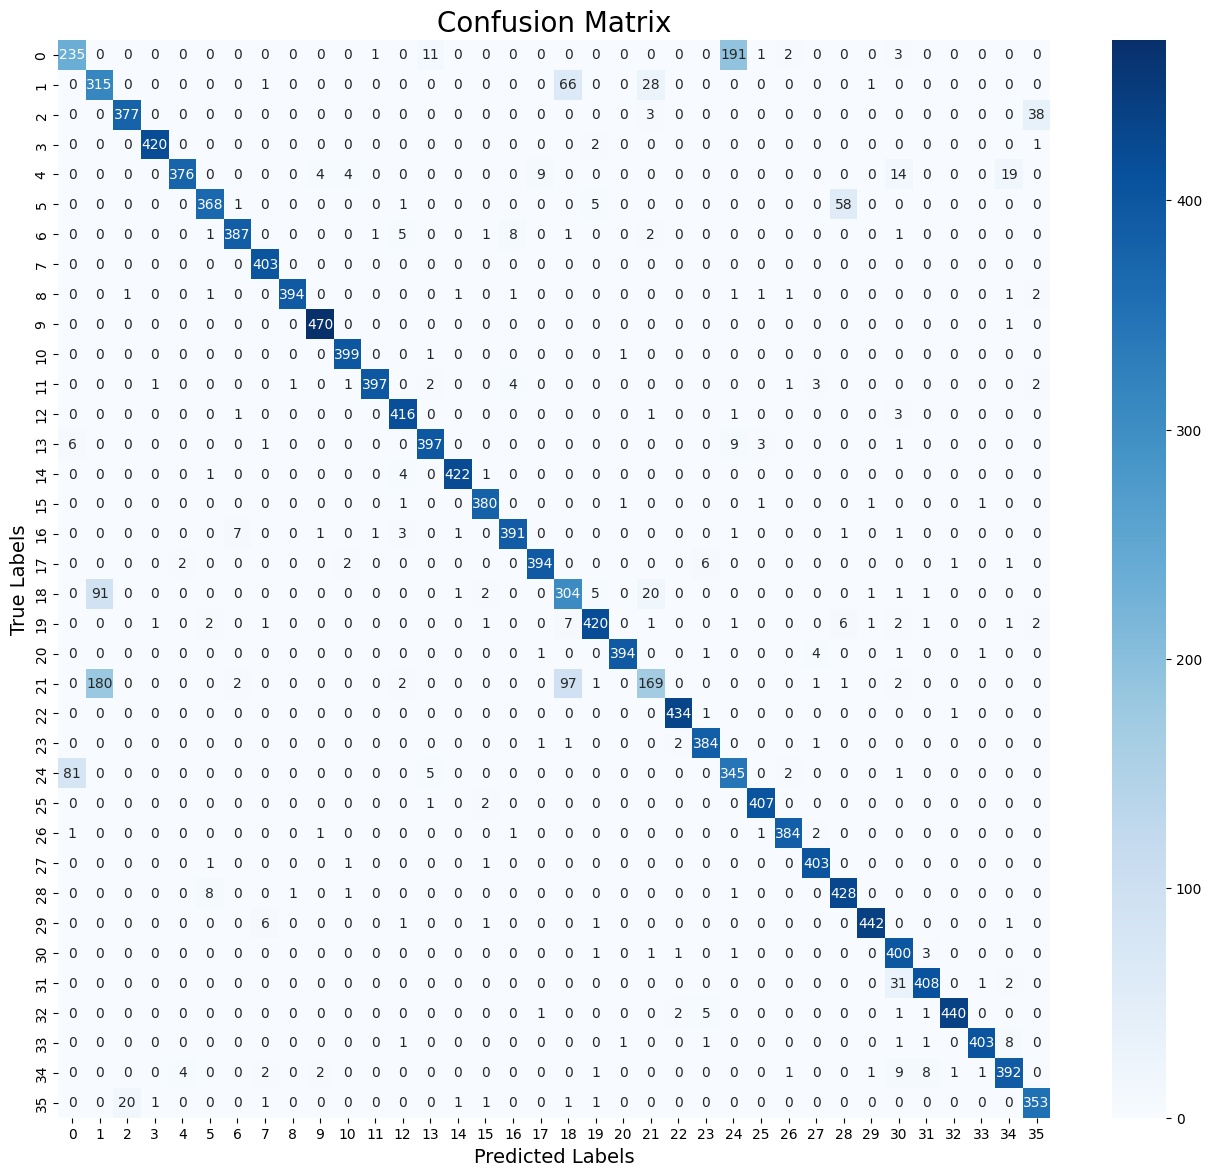

In [16]:
#Confusion Matrix
ConfusionMatrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))

sns.heatmap(ConfusionMatrix, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels', fontsize = 14)
plt.ylabel('True Labels', fontsize = 14)
plt.title('Confusion Matrix', fontsize = 20)

plt.show()

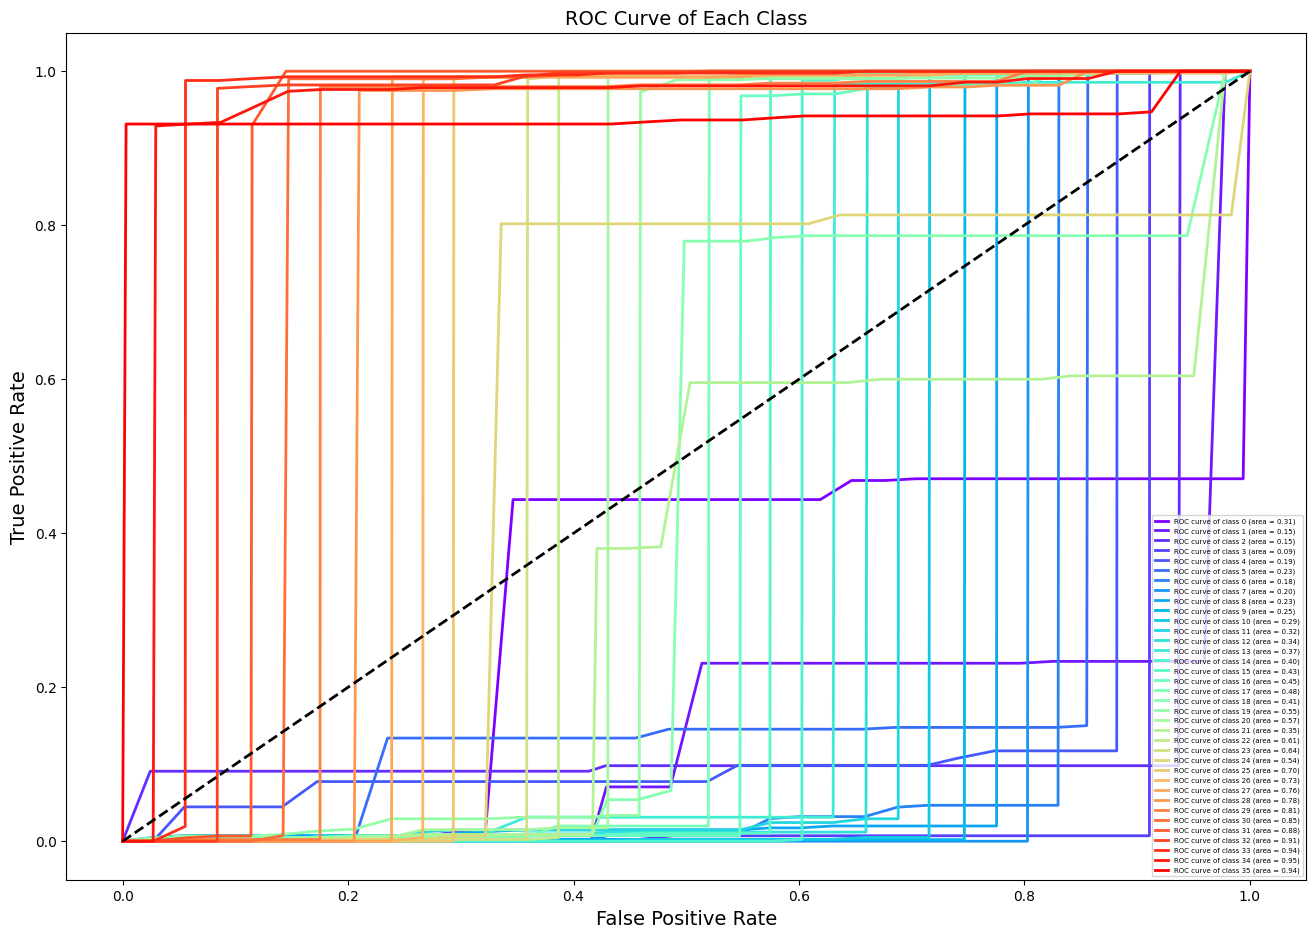

In [17]:
#ROC Curve
binarized_labels = label_binarize(all_labels, classes=list(range(36)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(36):

    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_preds)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 11))

for i, color in zip(range(36), plt.cm.rainbow(np.linspace(0, 1, 36))):

    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve of Each Class', fontsize=14)

plt.legend(loc="lower right", fontsize=5)

plt.show()

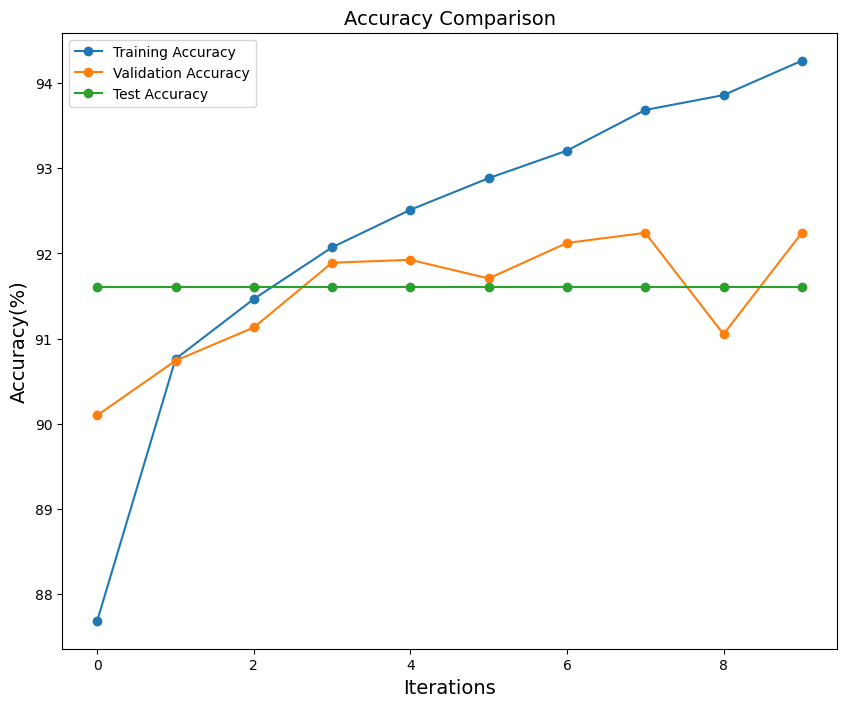

In [20]:
#Accuracy Graph
plt.figure(figsize=(10, 8))

plt.plot(Accuracy_List_Training, marker='o', label='Training Accuracy')
plt.plot(Accuracy_List_Validation, marker='o', label='Validation Accuracy')
plt.plot(Accuracy_List_Testing, marker='o', label='Test Accuracy')

plt.title('Accuracy Comparison', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Accuracy(%)', fontsize=14)

plt.legend()

plt.show()

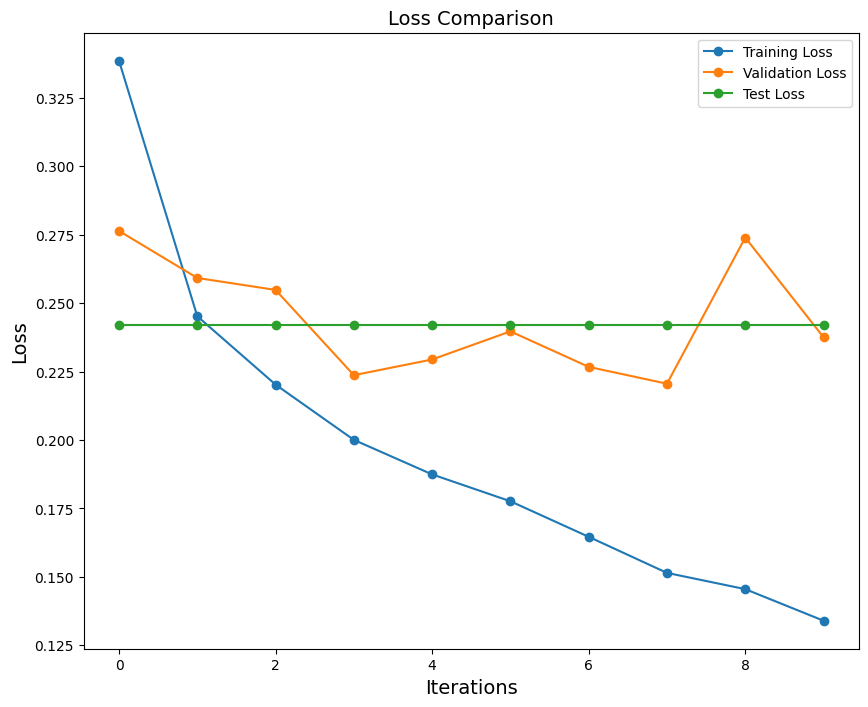

In [19]:
#Loss Graph
plt.figure(figsize=(10, 8))

plt.plot(Loss_List_Training, marker='o', label='Training Loss')
plt.plot(Loss_List_Validation, marker='o', label='Validation Loss')
plt.plot(Loss_List_Testing, marker='o', label='Test Loss')

plt.title('Loss Comparison', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()

plt.show()